# CHARIS MCMC

To speed things up, we use jax functions.

In [4]:
import multiprocessing as mp
import os
mp.set_start_method("spawn", force=True) # Jax was slowing down from os.fork() and this fixed it
os.environ["JAX_PLATFORM_NAME"] = "cpu" # Jax wasn't working with our GPU for unknown reasons
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
import re
from csv_tools import read_csv_physical_model_all_bins,arr_csv_HWP
from instruments_jax import *
from utils import generate_system_mueller_matrix
from pyMuellerMat.physical_models.charis_physical_models import HWP_retardance,IMR_retardance
from scipy import stats as scipy_stats
import h5py
import corner
import shutil
import tqdm

First, I'm going to read the CSVs for all wavelength bins at once so we can do a global fit. 

In [10]:
csv_dir = Path('datacsvs/csvs_pickoff')
interleaved_values_all, interleaved_stds_all, configuration_list_all = read_csv_physical_model_all_bins(csv_dir)


In [6]:
print(configuration_list_all)

[{'hwp': {'theta': 0.0, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 45.0, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 11.25, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 56.25, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 22.5, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 67.5, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 33.75, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 78.75, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 45.0, 'wavelength': 1159.5614}}, {'hwp': {'theta': 0.0, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 57.5, 'wavelength': 1159.5614}}, {'hwp':

Now, I'm going to set everything up for MCMC. 

In [7]:
# Getting the system dictionary setup and defining starting guesses values
wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
2139.4131, 2213.4641, 2290.0781, 2369.3441])
wavelength_bin = 15 # placeholder
epsilon_cal = 1 # defining as perfect, reasoning in Joost t Hart 2021
offset_imr = -0.01062 
offset_hwp = -0.0022 
offset_cal = -0.0315 
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
# Past fits from scipy minimize on the naive fits
d = 259.7 
wsio2 = 1.617
wmgf2 = 1.264

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
"components" : {
    "wollaston" : {
        "type" : "wollaston_prism_function",
        "properties" : {"beam": 'o'}, 
        "tag": "internal",
    },
    "image_rotator" : {
        "type" : "SCExAO_IMR_function",
        "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": d, "theta": imr_theta, "delta_theta": offset_imr},
        "tag": "internal",
    },
    "hwp" : {
        "type" : "two_layer_HWP_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
        "tag": "internal",
    },
    "lprot": { # changed from delta_theta to match Joost t Hart
        "type": "rotator_function",
        "properties" : {'pa':offset_cal},
        "tag": "internal",
    },
    "lp" : {  # calibration polarizer for internal calibration source
        "type": "diattenuator_retarder_function",
        "properties": {"epsilon": epsilon_cal},
        "tag": "internal",
    }}
}
    
# Starting guesses

p0_dict = {
    "image_rotator" : 
        {"d": d, "delta_theta": offset_imr},
    "hwp" :  
        {"w_SiO2": wsio2, "w_MgF2": wmgf2, "delta_theta": offset_hwp},
    "lprot" : 
        {"pa": offset_cal},
}

system_mm = generate_system_mueller_matrix(system_dict) # Generating pyMuellerMat system MM

p0 = [1.623, 1.268, 262.56] # Starting guesses from Joost t Hart 2021 
offset_bounds = (-5.0,5.0) # Wider bounds than first MCMC run, offsets were converging to their bounds at first
d_bounds = (0.8*p0[2], 1.2*p0[2]) # Physical parameters shouldn't have changed much
imr_offset_bounds = offset_bounds
wsio2_bounds = (0.8*p0[0], 1.2*p0[0])
wmgf2_bounds = (0.8*p0[1], 1.2*p0[1])
hwp_offset_bounds = offset_bounds
cal_offset_bounds = offset_bounds

bounds = {
    "image_rotator" : 
        {"d": d_bounds, "delta_theta": imr_offset_bounds},
    "hwp" :  
        {"w_SiO2": wsio2_bounds, "w_MgF2": wmgf2_bounds, "delta_theta": hwp_offset_bounds},
    "lprot" : 
        {"pa": cal_offset_bounds},
}

# define priors
prior_dict = {
    "image_rotator": {
        "d": {"type": "uniform", "kwargs": {"low":0.8*p0[2], "high": 1.2 * p0[2]}},
        "delta_theta": {"type": "gaussian", "kwargs": {"mu": 0, "sigma": 0.1}},
    },
    "hwp": {
        "w_SiO2": {"type": "uniform", "kwargs": {"low": 0.8*p0[0], "high": 1.2 * p0[0]}},
        "w_MgF2":{"type": "uniform", "kwargs": {"low": 0.8*p0[1], "high": 1.2 * p0[1]}},
        "delta_theta": {"type": "gaussian", "kwargs": {"mu": 0, "sigma": 0.1}},
    },
    "lprot": {
        "pa": {"type": "gaussian", "kwargs": {"mu": 0, "sigma": 0.1}},
    },
}

# backend h5
output_h5 = Path('mcmc_output_dds_pick_sigmapoint1_prior.h5')

In [11]:
# Minimize everything globally with least squares
    # Counters for iterative fitting
from vampires_calibration.fitting import minimize_system_mueller_matrix

iteration = 1
previous_logl = 1000000
new_logl = 0
boundslist = [d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
interleaved_difs = interleaved_values_all
difer = interleaved_stds_all

    # Perform iterative fitting
    # MODIFY THE BOUNDS INPUT HERE IF YOU WANT TO CHANGE PARAMETERS
while abs(previous_logl - new_logl) > 0.01*abs(previous_logl):
    if iteration > 1:
        previous_logl = new_logl
    # Configuring minimization function for CHARIS
    result, new_logl = minimize_system_mueller_matrix(p0_dict, system_mm, interleaved_difs, 
        difer, configuration_list_all,s_in=[1,0,0,0], process_dataset=process_dataset,process_model=process_model,process_errors=process_errors,bounds = boundslist,include_sums=False,mode='minimize')
    print(result)

    # Update p0 with new values

    update_p0(p0_dict, result.x)
    iteration += 1

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 10691115411.767704
        x: [ 2.597e+02 -5.000e+00  1.948e+00  1.014e+00  5.000e+00
            -3.150e-02]
      nit: 0
      jac: [ 1.910e+08  1.003e+08 -1.049e+10  1.054e+10 -0.000e+00
             0.000e+00]
     nfev: 147
     njev: 21
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 10691115411.767704
        x: [ 2.597e+02 -5.000e+00  1.948e+00  1.014e+00  5.000e+00
            -3.150e-02]
      nit: 0
      jac: [ 1.910e+08  1.003e+08 -1.049e+10  1.054e+10 -0.000e+00
             0.000e+00]
     nfev: 147
     njev: 21
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


Now I'm going to run the simulation. 

In [15]:
# Interactive plotting
%matplotlib notebook 
ndim = 6  # Number of parameters to fit
# Detect computing resources
pool_processes = max(1, 12) # Leaving one free
nwalkers = max(2 * ndim, pool_processes * 2)
if nwalkers % pool_processes != 0:
    nwalkers += pool_processes - (nwalkers % pool_processes)

print(f"Auto-detected: {pool_processes} processes, {nwalkers} walkers for {ndim} parameters")
sampler, p_keys = run_mcmc(p0_dict, system_mm, interleaved_values_all, interleaved_stds_all,configuration_list_all,prior_dict,bounds,logl_with_logf, output_h5,nwalkers=nwalkers, include_log_f=True, log_f=-3.0, pool_processes=pool_processes,process_model=process_model, process_errors=process_errors,process_dataset=process_dataset,nsteps=40000,plot=True, include_sums=False)

Auto-detected: 12 processes, 24 walkers for 6 parameters


<IPython.core.display.Javascript object>

 24%|██▍       | 9542/40000 [9:43:49<31:03:34,  3.67s/it]


KeyboardInterrupt: 

In [12]:
def plot_corner_flat(chain, param_names, step_range=(0, None), median_or_max="median", num_bins=100):
    flat_chain = chain[step_range[0]:step_range[1], :, :].reshape(-1, chain.shape[-1])
    converted_chain = flat_chain.copy()

    for i, name in enumerate(param_names):
        if ".phi" in name:
            converted_chain[:, i] = converted_chain[:, i] / (2 * np.pi)

    if median_or_max == "median":
        truths = np.median(converted_chain, axis=0)
    elif median_or_max == "max":
        truths = []
        for i in range(converted_chain.shape[1]):
            hist, bin_edges = np.histogram(converted_chain[:, i], bins=num_bins)
            max_index = np.argmax(hist)
            max_val = (bin_edges[max_index] + bin_edges[max_index + 1]) / 2
            truths.append(max_val)
        truths = np.array(truths)
    else:
        raise ValueError("median_or_max must be 'median' or 'max'")
 
    fig = corner.corner(
        converted_chain,
        labels = [name.replace("delta_theta", "offset").replace("image_rotator", "imr") for name in param_names],
        truths=truths,
        plot_datapoints=False, label_kwargs={"fontsize":3}   # disables individual scatter points
    )

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        ax.xaxis.labelpad = 40
        ax.yaxis.labelpad = 40

    plt.tick_params(axis='x', which='both', pad=5)
    plt.tick_params(axis='y', which='both', pad=5)
    return fig

def load_chain_and_labels(h5_filename, txt_filename, include_logf=False):
    base, ext = os.path.splitext(h5_filename)
    h5_copy = base + "_copy" + ext
    shutil.copy(h5_filename, h5_copy)

    with h5py.File(h5_copy, 'r') as f:
        chain = f['mcmc']['chain'][:]

    with open(txt_filename, 'r') as f:
        p0_dict = json.load(f)

    param_names = [f"{comp}.{param}" for comp, params in p0_dict.items() for param in params]
    if include_logf:
        param_names.append("log_f")

    return chain, param_names

(40000, 14, 7)


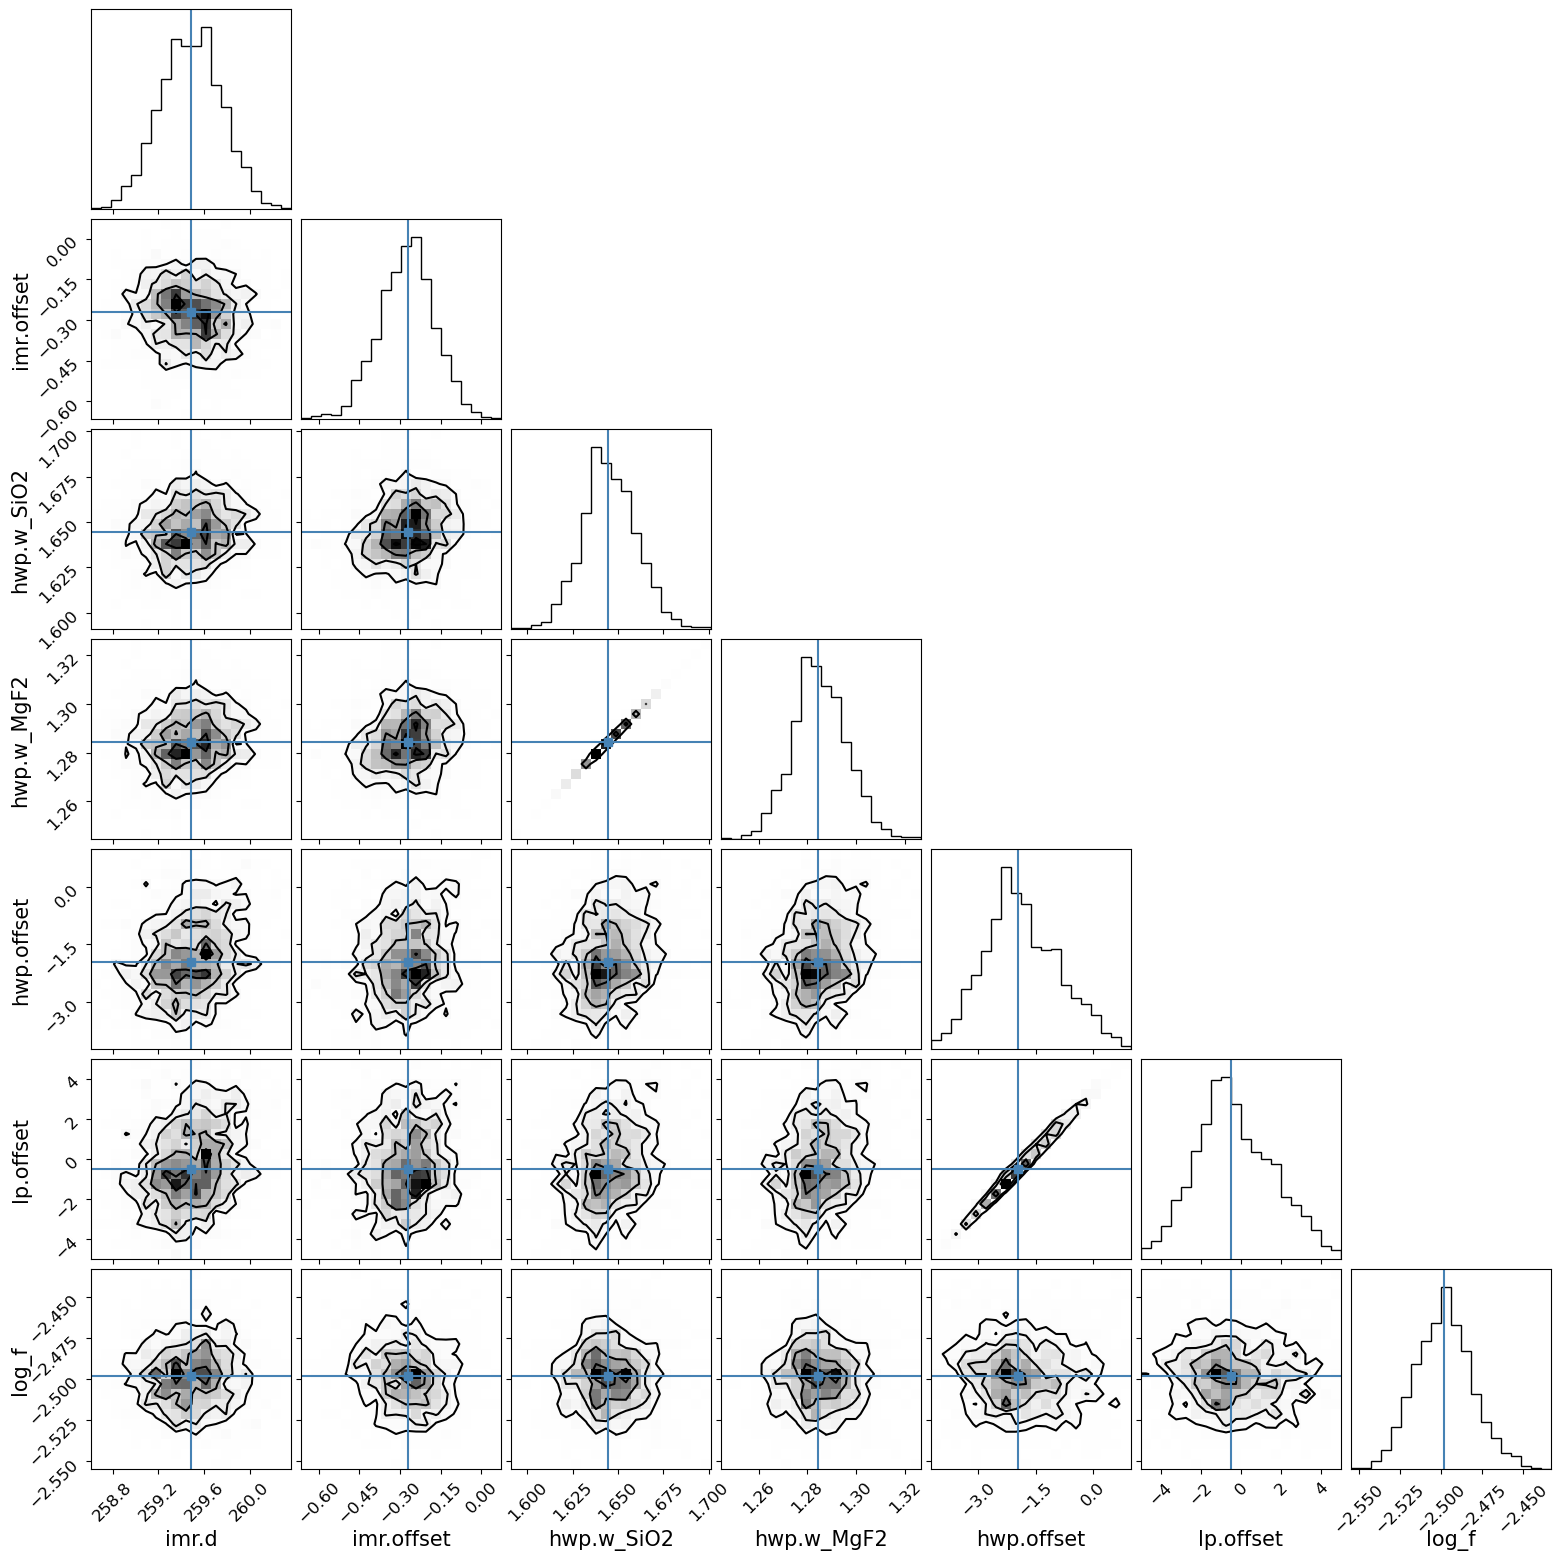

In [36]:
json_filepath = 'mcmc_p0_dict.json'
chain, names = load_chain_and_labels(output_h5, json_filepath, include_logf = True)
corner_plot_step_range = (15300,16000)
fig = plot_corner_flat(chain, names, step_range=corner_plot_step_range)
print(chain.shape)
for ax in fig.get_axes():
    if ax.xaxis.label:  # check label exists
        ax.xaxis.label.set_fontsize(15)  # your desired size
    if ax.yaxis.label:
        ax.yaxis.label.set_fontsize(15)


Looks like it converged nicely, but there is a clear degeneracy between the HWP offset and the LP offset. The degeneracy between the two HWP thicknesses seems reasonable.

Shape: (40000, 14, 7)
NaNs: False
Infs: False
Means: [104.45424905  -0.11170809   0.662411     0.51734372  -0.8034516
  -0.2433052 ]
Stds : [127.26602715   0.15240803   0.8071315    0.6303663    1.17201568
   1.30294641]


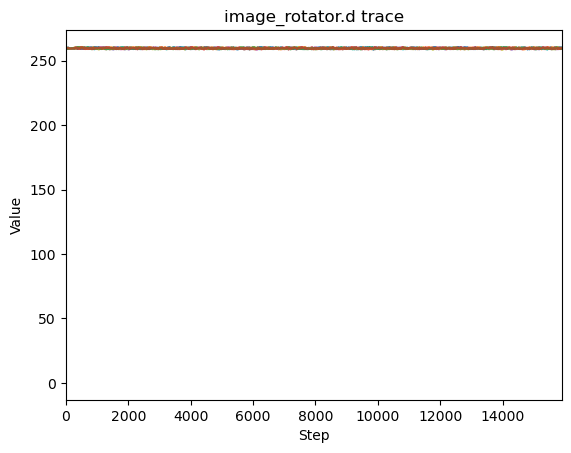

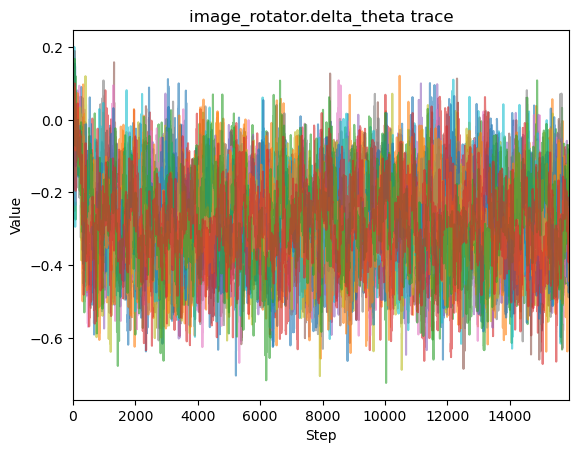

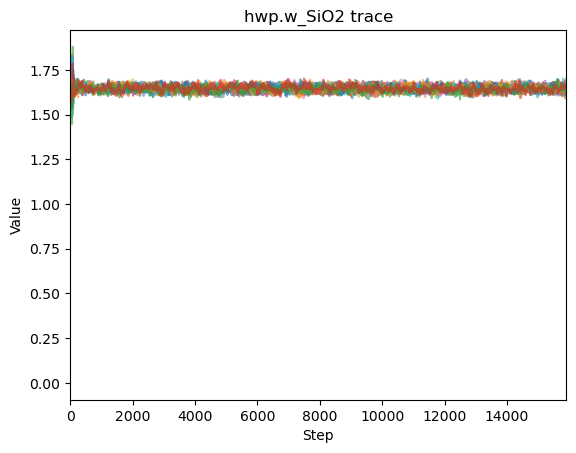

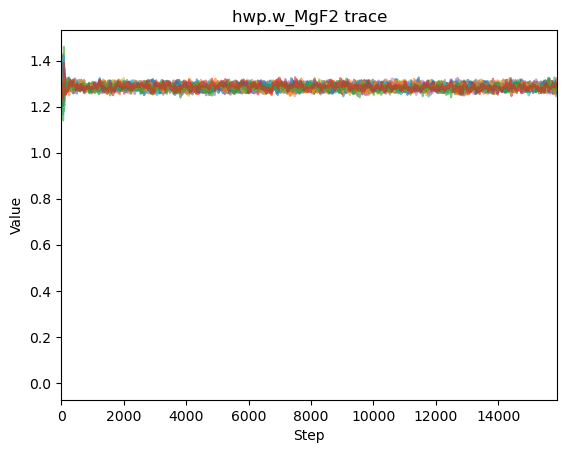

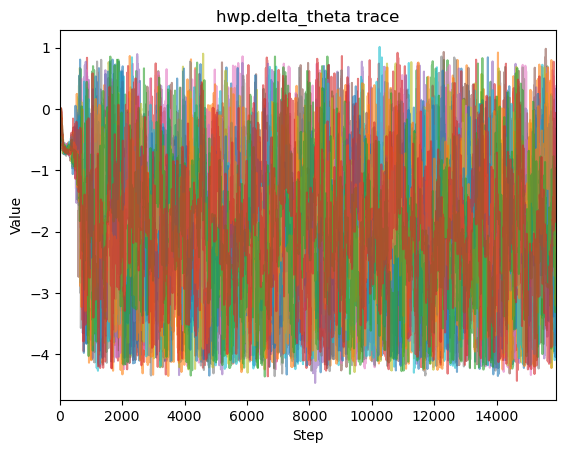

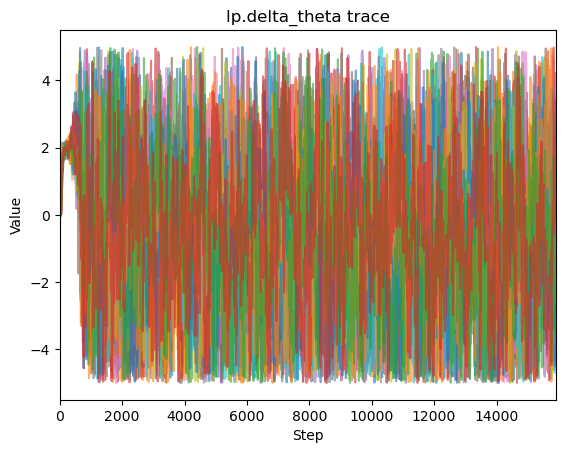

In [35]:
print("Shape:", chain.shape)
print("NaNs:", np.isnan(chain).any())
print("Infs:", np.isinf(chain).any())

means = np.mean(chain[:, :, :-1], axis=(0, 1))
stds = np.std(chain[:, :, :-1], axis=(0, 1))
print("Means:", means)
print("Stds :", stds)
for i in range(6):  # skip log(f)
    plt.figure()
    for w in range(14):
        plt.plot(chain[:, w, i], alpha=0.6)
        plt.xlim(0,15900)
    plt.title(f"{names[i]} trace")
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.show()

In [71]:
inst.summarize_median_posterior(output_h5,p0_dict,step_range=(8000,16000))


Posterior Medians and 1 sigma Credible Intervals:
image_rotator,d: 259.50747 (+0.25697/-0.25973)
image_rotator,delta_theta: -0.27842 (+0.10450/-0.10535)
hwp,w_SiO2: 1.64535 (+0.01395/-0.01380)
hwp,w_MgF2: 1.28501 (+0.01035/-0.01020)
hwp,delta_theta: -2.09738 (+1.04303/-1.01470)
lp,delta_theta: -0.79060 (+2.06934/-2.02202)


{'d': {'median': 259.50746657233975,
  '-1sigma': 0.2597310004093174,
  '+1sigma': 0.25696890428105235},
 'delta_theta': {'median': -0.7906034211926034,
  '-1sigma': 2.022023506822247,
  '+1sigma': 2.0693404855931012},
 'w_SiO2': {'median': 1.6453512171409417,
  '-1sigma': 0.013795243542661373,
  '+1sigma': 0.013945078977712244},
 'w_MgF2': {'median': 1.2850131158813587,
  '-1sigma': 0.010196693674887403,
  '+1sigma': 0.010346585381108664}}

There seem to be large errors on the hwp and lp offsets. Whatever is causing this degeneracy will require more investigation.